<a href="https://colab.research.google.com/github/hunghuyen0304/BTL_XLA/blob/main/DEMO_CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Đang chạy trên thiết bị: cpu

⏳ Đang load model...
✅ Load model thành công! Sẵn sàng demo.

--- CHƯƠNG TRÌNH NHẬN DIỆN CHỮ SỐ VIẾT TAY ---
Mời thầy/bạn chọn ảnh để kiểm tra:


Saving Ảnh chụp màn hình 2025-11-25 175939.png to Ảnh chụp màn hình 2025-11-25 175939.png

📸 Đang xử lý ảnh: Ảnh chụp màn hình 2025-11-25 175939.png


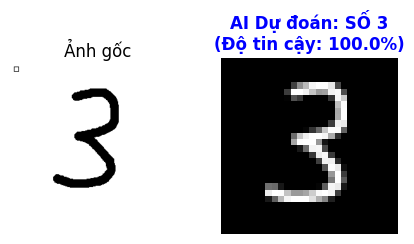

In [2]:
# --- PHẦN 1: IMPORT THƯ VIỆN ---
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import math

# Chọn thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Đang chạy trên thiết bị: {device}")


# --- PHẦN 2: KHAI BÁO KIẾN TRÚC MODEL (BẮT BUỘC) ---
# Máy tính cần biết khung xương của CNN trước khi nạp trọng số
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Layer 1: Nhìn chi tiết
        self.conv1 = nn.Conv2d(1, 24, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # Layer 2: Nhìn tổng quát
        self.conv2 = nn.Conv2d(24, 36, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(36 * 5 * 5, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10) # Output 10 số (0-9)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# --- PHẦN 3: LOAD MODEL TỪ FILE .PTH ---
print("\n⏳ Đang load model...")
cnn_model = CNN().to(device) # Tạo xác model

try:
    # Nạp "trí tuệ" (weights) vào xác model
    cnn_model.load_state_dict(torch.load('mnist_cnn_model.pth', map_location=device))
    cnn_model.eval() # Chuyển sang chế độ thi đấu (Demo)
    print("✅ Load model thành công! Sẵn sàng demo.")
except FileNotFoundError:
    print("❌ LỖI: Không tìm thấy file 'mnist_cnn_model.pth'.")
    print("👉 Hãy kéo thả file .pth vào mục Files bên trái màn hình rồi chạy lại.")


# --- PHẦN 4: HÀM XỬ LÝ ẢNH "XỊN" (PRE-PROCESSING) ---
def preprocess_digit(image_path):
    # Đọc ảnh xám
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return None

    # Tách nền và chữ (Otsu Threshold)
    # THRESH_BINARY_INV: Giả định ảnh gốc là nền trắng chữ đen -> Đảo thành nền đen chữ trắng
    _, img_binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

    # Lọc nhiễu
    kernel = np.ones((3,3), np.uint8)
    img_binary = cv2.morphologyEx(img_binary, cv2.MORPH_OPEN, kernel)

    # Tìm đường bao của chữ số
    contours, _ = cv2.findContours(img_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: return np.zeros((28, 28), dtype=np.float32)

    # Lấy đường bao lớn nhất (là chữ số)
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    digit_roi = img_binary[y:y+h, x:x+w]

    # Resize về 20x20 (giữ tỷ lệ)
    max_dim = max(w, h)
    scale_factor = 20.0 / max_dim
    new_w = int(w * scale_factor)
    new_h = int(h * scale_factor)
    digit_resized = cv2.resize(digit_roi, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Đặt vào giữa khung 28x28
    final_img = np.zeros((28, 28), dtype=np.uint8)
    start_x = (28 - new_w) // 2
    start_y = (28 - new_h) // 2
    final_img[start_y:start_y+new_h, start_x:start_x+new_w] = digit_resized

    return final_img.astype(np.float32) / 255.0

def predict_demo(image_path):
    # Xử lý ảnh
    processed_img = preprocess_digit(image_path)
    if processed_img is None: return

    # Dự đoán
    img_tensor = torch.tensor(processed_img).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        output = cnn_model(img_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        prediction = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][prediction].item() * 100

    # Hiển thị kết quả đẹp mắt
    plt.figure(figsize=(5, 3))

    # Ảnh gốc
    original_img = cv2.imread(image_path)
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title("Ảnh gốc")
    plt.axis('off')

    # Ảnh AI nhìn thấy
    plt.subplot(1, 2, 2)
    plt.imshow(processed_img, cmap='gray')
    plt.title(f"AI Dự đoán: SỐ {prediction}\n(Độ tin cậy: {confidence:.1f}%)", color='blue', fontweight='bold')
    plt.axis('off')
    plt.show()

# --- PHẦN 5: CHẠY DEMO ---
print("\n--- CHƯƠNG TRÌNH NHẬN DIỆN CHỮ SỐ VIẾT TAY ---")
print("Mời thầy/bạn chọn ảnh để kiểm tra:")
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\n📸 Đang xử lý ảnh: {filename}")
    predict_demo(filename)